In [1]:
import wandb

wandb.init(project="test3", entity="xhradskyp")

wandb: Currently logged in as: xhradskyp. Use `wandb login --relogin` to force relogin


In [2]:
# wandb 0579f7c3cd1c2f35057ca57bd211437e0212308f
# Dice score

# UNet

In [36]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torchvision
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import math
import time
from datetime import datetime
from torch.utils.data import random_split
from torchmetrics.functional import dice

In [3]:
class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = self.contract_block(in_channels, 32, 7, 3)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)

        self.upconv3 = self.expand_block(128, 64, 3, 1)
        self.upconv2 = self.expand_block(64*2, 32, 3, 1)
        self.upconv1 = self.expand_block(32*2, out_channels, 3, 1)

    def __call__(self, x):

        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)

        upconv3 = self.upconv3(conv3)

        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        return upconv1

    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                 )

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
                            )
        return expand

net = UNET(3, 1)

# Dataset

In [4]:
# def extract_blocks(images):
#     count,M,N,ch = images.shape
#     w, h = 64, 64
#     new = np.empty((count*16, w, h, ch), dtype=np.uint8)
#     i = 0
#     for image in images:
#         for j in range(4):
#             for k in range(4):
#                 new[i] = image[k*64:(k+1)*64, j*64:(j+1)*64]
#                 i += 1
#     return new

def extract_blocks(images):
    count,M,N,ch = images.shape
    w, h = 64, 64
    new = np.empty((count*49, w, h, ch), dtype=np.uint8)
    i = 0
    for image in images:
        for j in range(7):
            for k in range(7):
                new[i] = image[k*32:(k+1)*64-k*32, j*32:(j+1)*64-j*32]
                i += 1
    return new

class MyDataset(Dataset):
    def __init__(self):
        images = np.load("data/images.npy")
        labels = np.load("data/labels.npy")
        

        # images = extract_blocks(images).astype(np.uint8)
        # labels = extract_blocks(labels).astype(np.uint8)
        images = extract_blocks(images)
        print("done")
        labels = extract_blocks(labels)
        print("done")
        labels = labels[..., 1]
        labels[labels >= 1] = 1
        print("done")
        # images = images / 255
        # print("done")
        # labels = labels / 255
        # print("done")
        
        # labels = labels.astype(np.int32)
        # images = torch.tensor(images).type(torch.FloatTensor)
        # labels = torch.tensor(labels).type(torch.FloatTensor)
        images = torch.tensor(images)
        labels = torch.tensor(labels)
        print(images.shape)
        self.images = images.permute((0, 3, 1, 2))
        self.labels = labels

    def __getitem__(self, index):
        return self.images[index], self.labels[index]

    def __len__(self):
        return self.images.shape[0]

In [5]:
dataset = MyDataset()

done
done
done
torch.Size([244069, 64, 64, 3])


In [6]:
dataset[4002][1]

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1]], dtype=torch.uint8)

In [7]:
print(dataset[0][0].shape)
print(dataset[0][1].shape)

torch.Size([3, 64, 64])
torch.Size([64, 64])


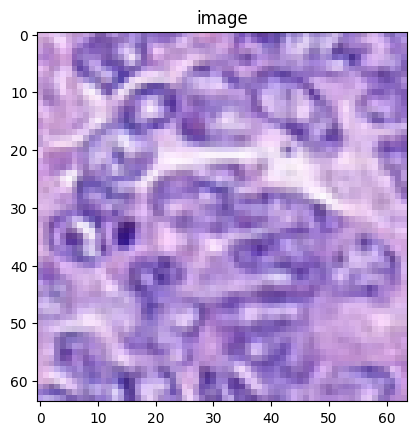

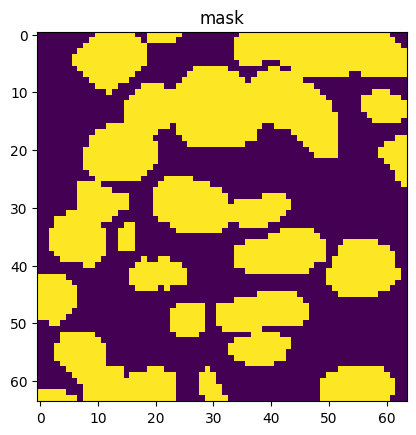

In [8]:
x = 123
plt.imshow(dataset[x][0].float().permute((1, 2, 0)).detach().numpy()/255)
plt.title("image")
plt.show()
plt.imshow(dataset[x][1].float().detach().numpy())
plt.title("mask")
plt.show()

In [9]:
train_data, test_data = random_split(dataset, [200000, 44069])
# train_data, test_data = random_split(dataset, [70000, 9696])

In [12]:
dataloader = DataLoader(dataset=train_data, batch_size=4, shuffle=True)

# Train

In [14]:
dataiter = iter(dataloader)
data = dataiter.next()
features, labels = data
pred = net(features)
print(features.shape, labels.shape, pred.shape, pred.squeeze(1).shape)
print(features.type(), labels.type(), pred.type(), pred.squeeze(1).type())
loss_fn(pred.squeeze(1), labels)

torch.Size([64, 3, 64, 64]) torch.Size([64, 64, 64]) torch.Size([64, 1, 64, 64]) torch.Size([64, 64, 64])
torch.FloatTensor torch.FloatTensor torch.FloatTensor torch.FloatTensor


RuntimeError: Expected target size [64, 64], got [64, 64, 64]

In [43]:
num_epochs = 4
total_samples = len(train_data)
n_iterations = math.ceil(total_samples/4)
print(total_samples, n_iterations)
net = UNET(3, 1)
# net = UNet()
loss_fn = nn.CrossEntropyLoss()
# loss_fn = nn.BCEWithLogitsLoss()
opt = torch.optim.Adam(net.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
def acc_metric(predb, yb):
    return (predb.argmax(dim=1) == yb).float().mean()

200000 50000


In [44]:
start_time = datetime.now()
for epoch in range(num_epochs):
    avg_loss = 0
    avg_acc = 0
    for i, (inputs, labels) in enumerate(dataloader):
        opt.zero_grad()
        outputs = net(inputs.float())
        loss = loss_fn(outputs.squeeze(1), labels.float())
        # loss = loss_fn(outputs, labels)
        
        loss.backward()
        opt.step()
        acc = dice(outputs, labels)
        wandb.log({"loss_2": loss})
        wandb.log({"acc_2": acc})
        # forward, backwards, update
        avg_loss += loss.item()
        avg_acc += acc
        if (i+1) % 100 == 0:
            print(f'epoch {epoch+1}/{num_epochs}, step {i+1}/{n_iterations}, loss {avg_loss/100}, acc {avg_acc/100}, time {(datetime.now()-start_time)}')
            avg_loss = 0
            avg_acc = 0
        if (i+1) % 1000 == 0:
            plt.imshow(inputs[0].permute((1, 2, 0)).detach().numpy()/255)
            plt.show()
            plt.imshow(outputs[0][0].detach().numpy())
            plt.show()
            plt.imshow(labels[0].detach().numpy())
            plt.show()

epoch 1/4, step 100/50000, loss 39.896157984733584, acc 6.842285529273795e-06, time 0:00:27.984170
epoch 1/4, step 200/50000, loss 40.218315801620484, acc 0.0, time 0:00:56.405440
epoch 1/4, step 300/50000, loss 37.59137253522873, acc 0.0, time 0:01:24.300543
epoch 1/4, step 400/50000, loss 36.707914476394656, acc 0.0, time 0:01:52.736988
epoch 1/4, step 500/50000, loss 39.3450002861023, acc 0.0, time 0:02:28.878707
epoch 1/4, step 600/50000, loss 37.32482738494873, acc 0.0, time 0:03:06.703736
epoch 1/4, step 700/50000, loss 34.7919237613678, acc 0.0, time 0:03:34.814112


KeyboardInterrupt: 

In [14]:
torch.save(net, "net25")

In [55]:
net = UNET(3, 1)
net = torch.load("net20")
# net20 - BCE
# net24 - Cross

# Visualisation

torch.Size([4, 1, 64, 64])
tensor(0.6980)


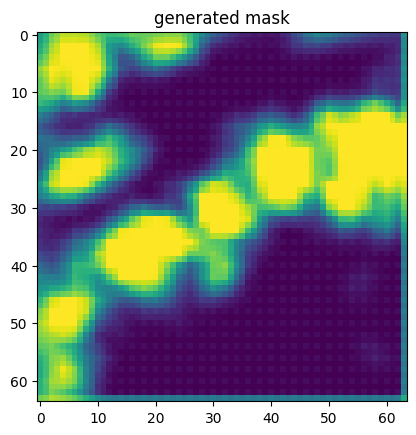

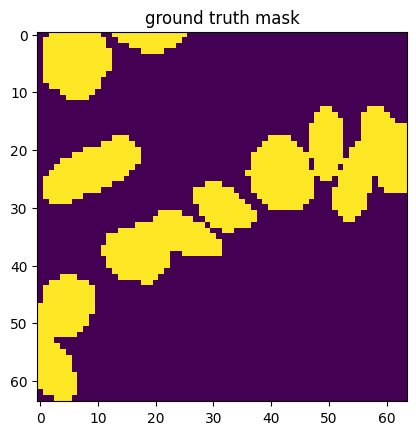

In [58]:
dataloader_test = DataLoader(dataset=test_data, batch_size=1, shuffle=True)
dataiter = iter(dataloader)
data = next(dataiter)
features, labels = data
with torch.no_grad():
    outputs = net(features.float())
    print(outputs.shape)
    # print(dice_metric(outputs, labels))
    print(dice(outputs, labels))
    plt.imshow(outputs[0][0].detach().numpy())
    plt.title("generated mask")
    plt.show()
    plt.imshow(labels[0].detach().numpy())
    plt.title("ground truth mask")
    plt.show()

[[-2.064506   -1.9660544  -1.5305656  ... -0.15285748 -0.2782197
  -0.16376266]
 [-2.4727411  -2.0837994  -1.4233997  ... -0.51272285 -1.2316539
  -0.6446049 ]
 [-2.427553   -1.9436133  -1.0958937  ... -0.9879867  -1.8736792
  -1.0650325 ]
 ...
 [-5.4758387  -5.918803   -5.9601603  ... -2.462179   -2.299632
  -1.2445924 ]
 [-5.0477114  -5.66778    -5.382999   ... -3.4752054  -2.974811
  -1.6870584 ]
 [-2.6039367  -3.2358184  -2.7764106  ... -1.9953911  -1.537624
  -1.0107033 ]]


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

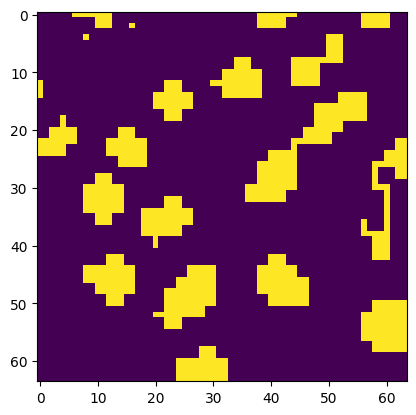

In [32]:
output = outputs[0][0].detach().numpy().copy()
print(output)
# target = output[0][0]
target = np.max(output)
output[output == target] = 1
output[output != 1] = 0
plt.imshow(output)
output
dice_metric

# test

In [12]:
net = UNET(3, 1)

In [13]:
xb, yb = next(iter(dataloader))
xb.shape, yb.shape

(torch.Size([64, 3, 64, 64]), torch.Size([64, 64, 64]))

In [14]:
import time
def train(model, train_dl, valid_dl, loss_fn, optimizer, acc_fn, epochs=1):
    start = time.time()

    train_loss, valid_loss = [], []

    best_acc = 0.0

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train(True)  # Set trainind mode = true
                dataloader = train_dl
            else:
                model.train(False)  # Set model to evaluate mode
                dataloader = valid_dl

            running_loss = 0.0
            running_acc = 0.0

            step = 0

            # iterate over data
            for x, y in dataloader:
                step += 1

                # forward pass
                if phase == 'train':
                    # zero the gradients
                    optimizer.zero_grad()
                    outputs = model(x.float())
                    loss = loss_fn(outputs.squeeze(1), y.float())

                    # the backward pass frees the graph memory, so there is no 
                    # need for torch.no_grad in this training pass
                    loss.backward()
                    optimizer.step()
                    # scheduler.step()

                else:
                    with torch.no_grad():
                        outputs = model(x.float())
                        loss = loss_fn(outputs.squeeze(1), y.float())

                # stats - whatever is the phase
                acc = acc_fn(outputs, y)

                running_acc  += acc*dataloader.batch_size
                running_loss += loss*dataloader.batch_size 

                if step % 10 == 0:
                    # clear_output(wait=True)
                    print('Current step: {}  Loss: {}  Acc: {}  AllocMem (Mb): {}'.format(step, loss, acc, torch.cuda.memory_allocated()/1024/1024))
                    # print(torch.cuda.memory_summary())
                if step % 100 == 0:
                    plt.imshow(x[0].permute((1, 2, 0)).detach().numpy())
                    plt.show()
                    plt.imshow(outputs[0].permute((1, 2, 0)).detach().numpy())
                    plt.show()
                    plt.imshow(y[0].detach().numpy())
                    plt.show()

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_acc / len(dataloader.dataset)

            print('{} Loss: {:.4f} Acc: {}'.format(phase, epoch_loss, epoch_acc))

            train_loss.append(epoch_loss) if phase=='train' else valid_loss.append(epoch_loss)

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
    return train_loss, valid_loss    

def acc_metric(predb, yb):
    return (predb.argmax(dim=1) == yb).float().mean()

In [15]:
train_dl = DataLoader(dataset=train_data, batch_size=32, shuffle=True)
valid_dl = DataLoader(dataset=test_data, batch_size=32, shuffle=True)

Epoch 0/4
----------
Current step: 10  Loss: 0.7544338703155518  Acc: 0.8262710571289062  AllocMem (Mb): 0.0
Current step: 20  Loss: 0.7443320751190186  Acc: 0.7994918823242188  AllocMem (Mb): 0.0
Current step: 30  Loss: 0.7425114512443542  Acc: 0.8455276489257812  AllocMem (Mb): 0.0
Current step: 40  Loss: 0.7353823184967041  Acc: 0.867767333984375  AllocMem (Mb): 0.0
Current step: 50  Loss: 0.7156174778938293  Acc: 0.7918472290039062  AllocMem (Mb): 0.0
Current step: 60  Loss: 0.7120677828788757  Acc: 0.8642807006835938  AllocMem (Mb): 0.0
Current step: 70  Loss: 0.6998891830444336  Acc: 0.8546905517578125  AllocMem (Mb): 0.0
Current step: 80  Loss: 0.6882039308547974  Acc: 0.8452301025390625  AllocMem (Mb): 0.0
Current step: 90  Loss: 0.6781886219978333  Acc: 0.8619766235351562  AllocMem (Mb): 0.0
Current step: 100  Loss: 0.6679642200469971  Acc: 0.8676223754882812  AllocMem (Mb): 0.0


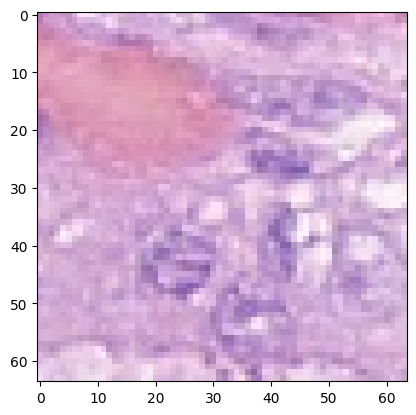

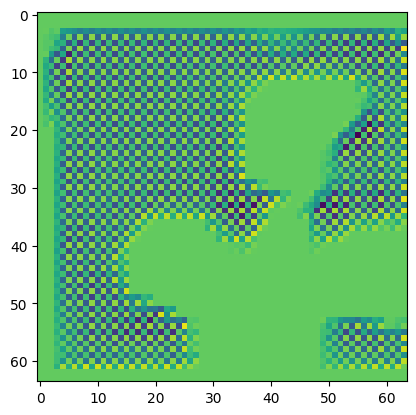

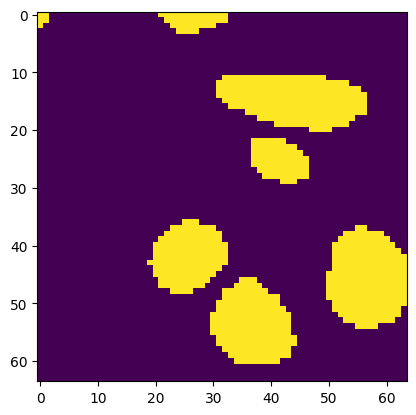

Current step: 110  Loss: 0.655971348285675  Acc: 0.797821044921875  AllocMem (Mb): 0.0
Current step: 120  Loss: 0.6452819108963013  Acc: 0.8473281860351562  AllocMem (Mb): 0.0
Current step: 130  Loss: 0.6328831911087036  Acc: 0.8341522216796875  AllocMem (Mb): 0.0
Current step: 140  Loss: 0.6212896108627319  Acc: 0.852020263671875  AllocMem (Mb): 0.0
Current step: 150  Loss: 0.6096585988998413  Acc: 0.8602371215820312  AllocMem (Mb): 0.0
Current step: 160  Loss: 0.6045867204666138  Acc: 0.8115921020507812  AllocMem (Mb): 0.0
Current step: 170  Loss: 0.5895224809646606  Acc: 0.8201446533203125  AllocMem (Mb): 0.0
Current step: 180  Loss: 0.5786511898040771  Acc: 0.8176040649414062  AllocMem (Mb): 0.0
Current step: 190  Loss: 0.5652642846107483  Acc: 0.8658676147460938  AllocMem (Mb): 0.0
Current step: 200  Loss: 0.5594432353973389  Acc: 0.8392181396484375  AllocMem (Mb): 0.0


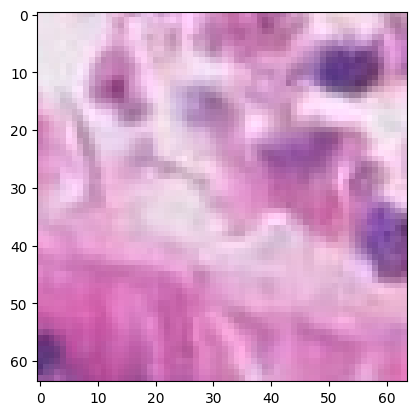

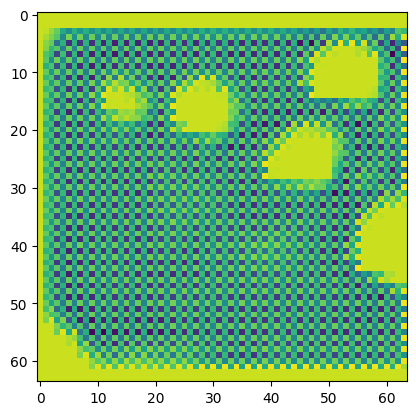

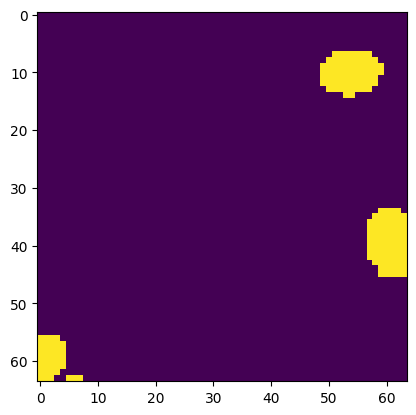

Current step: 210  Loss: 0.548746645450592  Acc: 0.815704345703125  AllocMem (Mb): 0.0
Current step: 220  Loss: 0.5337967872619629  Acc: 0.8665542602539062  AllocMem (Mb): 0.0
Current step: 230  Loss: 0.5278767347335815  Acc: 0.8520050048828125  AllocMem (Mb): 0.0
Current step: 240  Loss: 0.522214412689209  Acc: 0.8329696655273438  AllocMem (Mb): 0.0
Current step: 250  Loss: 0.5077609419822693  Acc: 0.849365234375  AllocMem (Mb): 0.0
Current step: 260  Loss: 0.5019533634185791  Acc: 0.8354568481445312  AllocMem (Mb): 0.0
Current step: 270  Loss: 0.49533969163894653  Acc: 0.8370895385742188  AllocMem (Mb): 0.0
Current step: 280  Loss: 0.4809597134590149  Acc: 0.84765625  AllocMem (Mb): 0.0
Current step: 290  Loss: 0.4693124294281006  Acc: 0.8500823974609375  AllocMem (Mb): 0.0
Current step: 300  Loss: 0.45999953150749207  Acc: 0.8546905517578125  AllocMem (Mb): 0.0


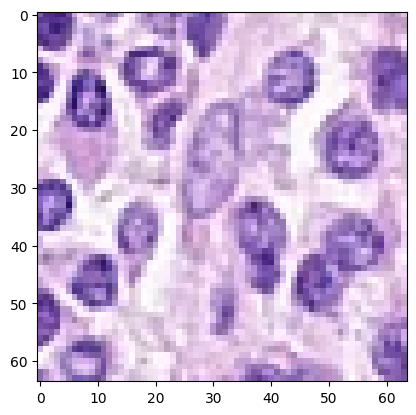

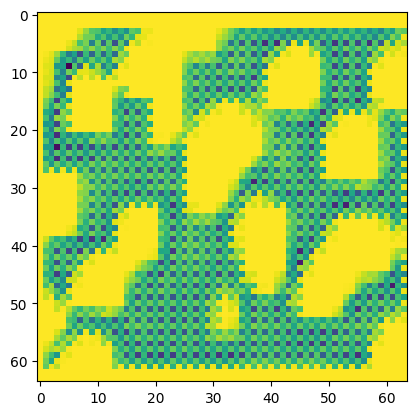

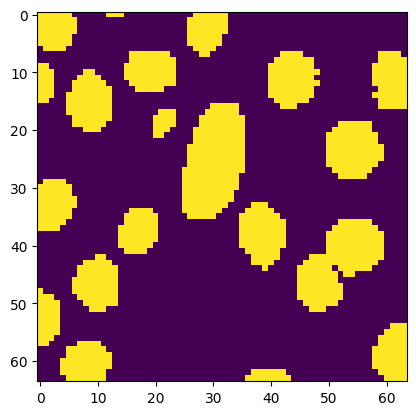

Current step: 310  Loss: 0.4699719548225403  Acc: 0.8095626831054688  AllocMem (Mb): 0.0
Current step: 320  Loss: 0.4575059115886688  Acc: 0.8306427001953125  AllocMem (Mb): 0.0
Current step: 330  Loss: 0.4470809996128082  Acc: 0.8266448974609375  AllocMem (Mb): 0.0
Current step: 340  Loss: 0.4401840567588806  Acc: 0.8184890747070312  AllocMem (Mb): 0.0
Current step: 350  Loss: 0.42488527297973633  Acc: 0.8685684204101562  AllocMem (Mb): 0.0
Current step: 360  Loss: 0.4267656207084656  Acc: 0.844207763671875  AllocMem (Mb): 0.0
Current step: 370  Loss: 0.4185676872730255  Acc: 0.8350677490234375  AllocMem (Mb): 0.0
Current step: 380  Loss: 0.40782997012138367  Acc: 0.8351974487304688  AllocMem (Mb): 0.0
Current step: 390  Loss: 0.39659225940704346  Acc: 0.8565750122070312  AllocMem (Mb): 0.0
Current step: 400  Loss: 0.38639044761657715  Acc: 0.8770828247070312  AllocMem (Mb): 0.0


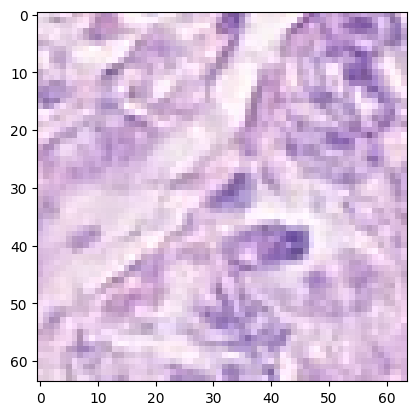

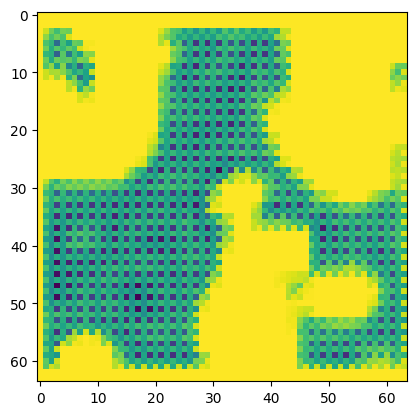

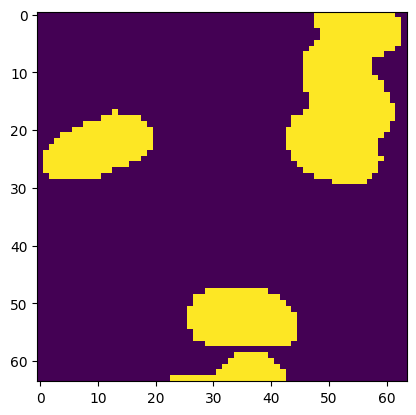

Current step: 410  Loss: 0.3976447880268097  Acc: 0.8514480590820312  AllocMem (Mb): 0.0
Current step: 420  Loss: 0.38811397552490234  Acc: 0.8611068725585938  AllocMem (Mb): 0.0
Current step: 430  Loss: 0.37005725502967834  Acc: 0.875946044921875  AllocMem (Mb): 0.0
Current step: 440  Loss: 0.393574982881546  Acc: 0.8233184814453125  AllocMem (Mb): 0.0
Current step: 450  Loss: 0.3844950795173645  Acc: 0.816375732421875  AllocMem (Mb): 0.0
Current step: 460  Loss: 0.3561546206474304  Acc: 0.8594284057617188  AllocMem (Mb): 0.0
Current step: 470  Loss: 0.3697483539581299  Acc: 0.8278427124023438  AllocMem (Mb): 0.0
Current step: 480  Loss: 0.3524089753627777  Acc: 0.848724365234375  AllocMem (Mb): 0.0
Current step: 490  Loss: 0.3588773012161255  Acc: 0.8302383422851562  AllocMem (Mb): 0.0
Current step: 500  Loss: 0.35070109367370605  Acc: 0.8434524536132812  AllocMem (Mb): 0.0


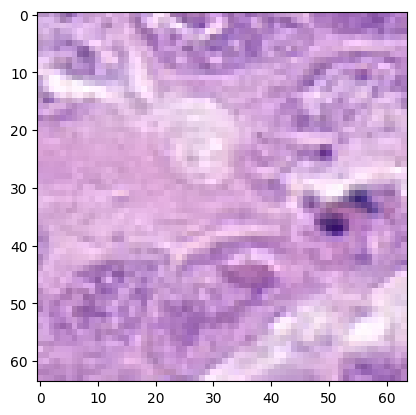

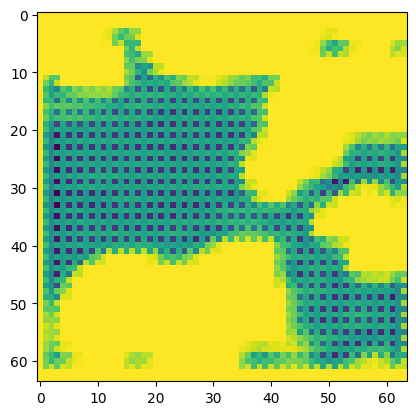

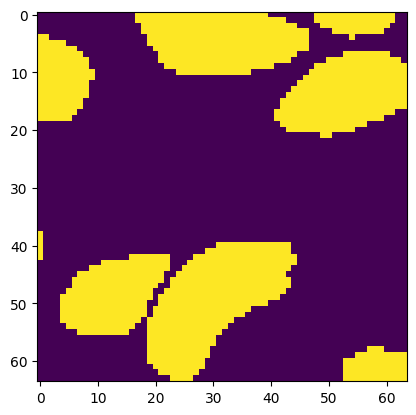

Current step: 510  Loss: 0.35702764987945557  Acc: 0.8440780639648438  AllocMem (Mb): 0.0
Current step: 520  Loss: 0.33197563886642456  Acc: 0.8602523803710938  AllocMem (Mb): 0.0
Current step: 530  Loss: 0.3324740529060364  Acc: 0.85260009765625  AllocMem (Mb): 0.0
Current step: 540  Loss: 0.34194955229759216  Acc: 0.8431396484375  AllocMem (Mb): 0.0
Current step: 550  Loss: 0.31498056650161743  Acc: 0.8737335205078125  AllocMem (Mb): 0.0
Current step: 560  Loss: 0.3190322816371918  Acc: 0.8674087524414062  AllocMem (Mb): 0.0
Current step: 570  Loss: 0.347739040851593  Acc: 0.8173141479492188  AllocMem (Mb): 0.0
Current step: 580  Loss: 0.3373621106147766  Acc: 0.8271026611328125  AllocMem (Mb): 0.0
Current step: 590  Loss: 0.29652640223503113  Acc: 0.8895645141601562  AllocMem (Mb): 0.0
Current step: 600  Loss: 0.33795905113220215  Acc: 0.8142623901367188  AllocMem (Mb): 0.0


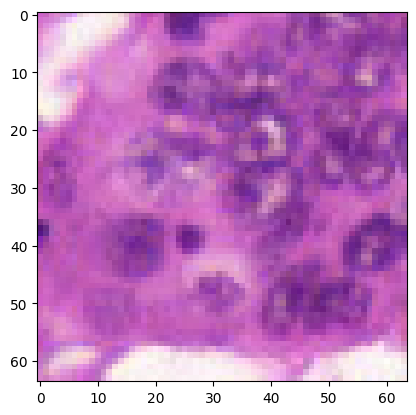

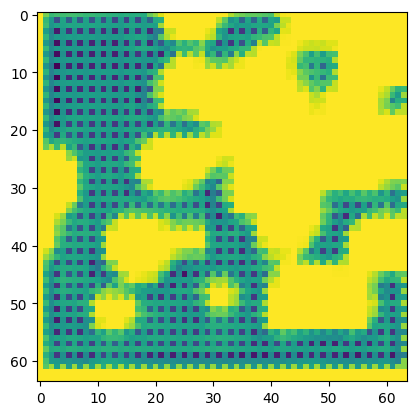

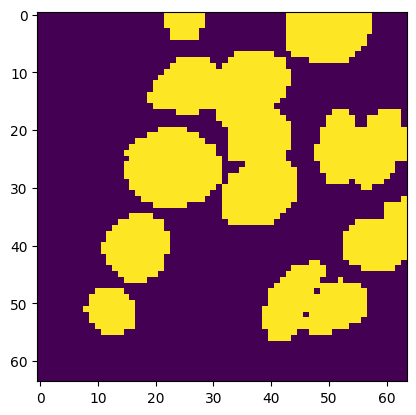

Current step: 610  Loss: 0.3262067437171936  Acc: 0.8130264282226562  AllocMem (Mb): 0.0
Current step: 620  Loss: 0.31947511434555054  Acc: 0.8350067138671875  AllocMem (Mb): 0.0
Current step: 630  Loss: 0.3175640404224396  Acc: 0.8291091918945312  AllocMem (Mb): 0.0
Current step: 640  Loss: 0.312248557806015  Acc: 0.8446273803710938  AllocMem (Mb): 0.0
Current step: 650  Loss: 0.3133230209350586  Acc: 0.8388824462890625  AllocMem (Mb): 0.0
Current step: 660  Loss: 0.2981700897216797  Acc: 0.8451995849609375  AllocMem (Mb): 0.0
Current step: 670  Loss: 0.31579655408859253  Acc: 0.8204116821289062  AllocMem (Mb): 0.0
Current step: 680  Loss: 0.3149873614311218  Acc: 0.8129806518554688  AllocMem (Mb): 0.0
Current step: 690  Loss: 0.2955954968929291  Acc: 0.8507614135742188  AllocMem (Mb): 0.0
Current step: 700  Loss: 0.294921875  Acc: 0.844635009765625  AllocMem (Mb): 0.0


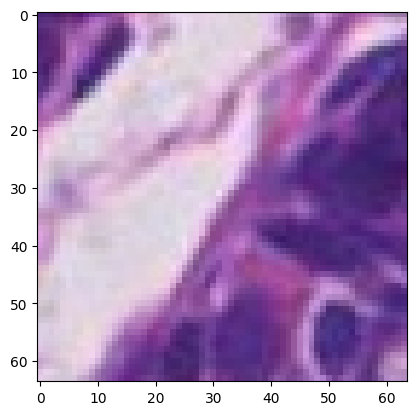

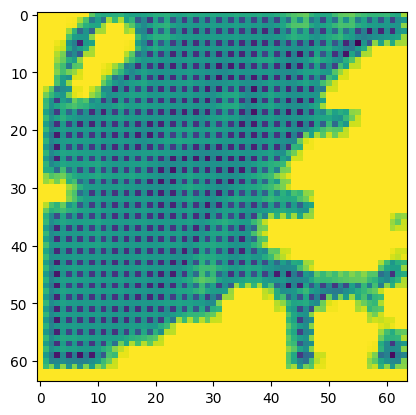

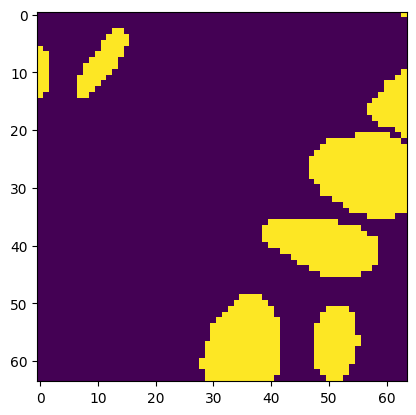

Current step: 710  Loss: 0.32558590173721313  Acc: 0.801910400390625  AllocMem (Mb): 0.0
Current step: 720  Loss: 0.29124218225479126  Acc: 0.8386383056640625  AllocMem (Mb): 0.0
Current step: 730  Loss: 0.2843557596206665  Acc: 0.852325439453125  AllocMem (Mb): 0.0
Current step: 740  Loss: 0.260771244764328  Acc: 0.8743362426757812  AllocMem (Mb): 0.0
Current step: 750  Loss: 0.28923845291137695  Acc: 0.8353805541992188  AllocMem (Mb): 0.0
Current step: 760  Loss: 0.27329781651496887  Acc: 0.860260009765625  AllocMem (Mb): 0.0
Current step: 770  Loss: 0.29511719942092896  Acc: 0.8233718872070312  AllocMem (Mb): 0.0
Current step: 780  Loss: 0.2693979740142822  Acc: 0.8543472290039062  AllocMem (Mb): 0.0
Current step: 790  Loss: 0.29850703477859497  Acc: 0.82513427734375  AllocMem (Mb): 0.0
Current step: 800  Loss: 0.2808185815811157  Acc: 0.84295654296875  AllocMem (Mb): 0.0


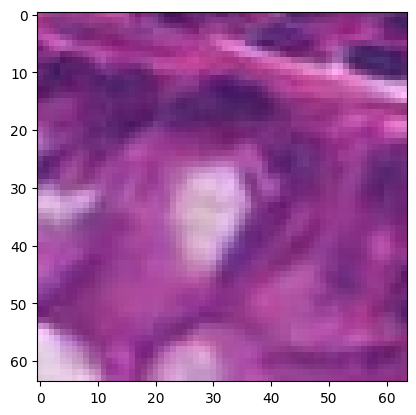

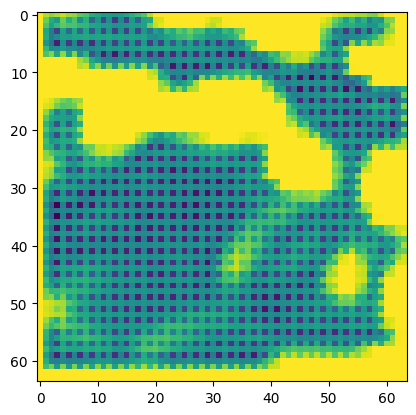

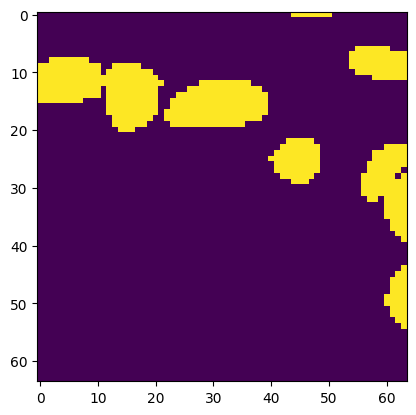

Current step: 810  Loss: 0.30218932032585144  Acc: 0.8092041015625  AllocMem (Mb): 0.0
Current step: 820  Loss: 0.2693101763725281  Acc: 0.8472976684570312  AllocMem (Mb): 0.0
Current step: 830  Loss: 0.299195259809494  Acc: 0.815765380859375  AllocMem (Mb): 0.0
Current step: 840  Loss: 0.23254765570163727  Acc: 0.891998291015625  AllocMem (Mb): 0.0
Current step: 850  Loss: 0.2583872675895691  Acc: 0.8564071655273438  AllocMem (Mb): 0.0
Current step: 860  Loss: 0.2685338854789734  Acc: 0.85272216796875  AllocMem (Mb): 0.0
Current step: 870  Loss: 0.2849145829677582  Acc: 0.8378677368164062  AllocMem (Mb): 0.0
Current step: 880  Loss: 0.2916107475757599  Acc: 0.8282318115234375  AllocMem (Mb): 0.0
Current step: 890  Loss: 0.2664933204650879  Acc: 0.8451309204101562  AllocMem (Mb): 0.0
Current step: 900  Loss: 0.2785325050354004  Acc: 0.835540771484375  AllocMem (Mb): 0.0


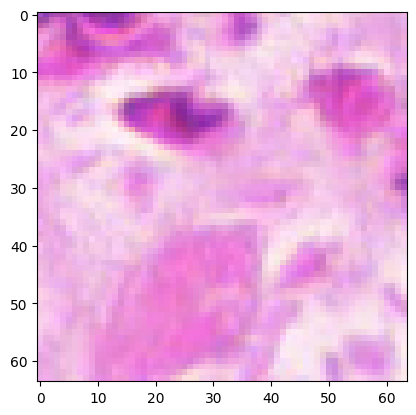

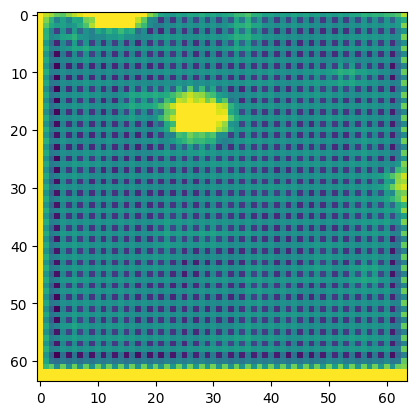

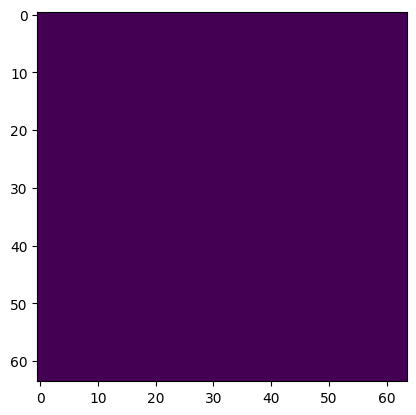

Current step: 910  Loss: 0.26105764508247375  Acc: 0.8480148315429688  AllocMem (Mb): 0.0
Current step: 920  Loss: 0.27661171555519104  Acc: 0.82769775390625  AllocMem (Mb): 0.0
Current step: 930  Loss: 0.26266634464263916  Acc: 0.8493881225585938  AllocMem (Mb): 0.0
Current step: 940  Loss: 0.3079676628112793  Acc: 0.8006973266601562  AllocMem (Mb): 0.0
Current step: 950  Loss: 0.26520565152168274  Acc: 0.8380966186523438  AllocMem (Mb): 0.0
Current step: 960  Loss: 0.25552845001220703  Acc: 0.8473968505859375  AllocMem (Mb): 0.0
Current step: 970  Loss: 0.2901245057582855  Acc: 0.8109817504882812  AllocMem (Mb): 0.0
Current step: 980  Loss: 0.24379712343215942  Acc: 0.8761749267578125  AllocMem (Mb): 0.0
Current step: 990  Loss: 0.2752414643764496  Acc: 0.84320068359375  AllocMem (Mb): 0.0
Current step: 1000  Loss: 0.24754464626312256  Acc: 0.8571319580078125  AllocMem (Mb): 0.0


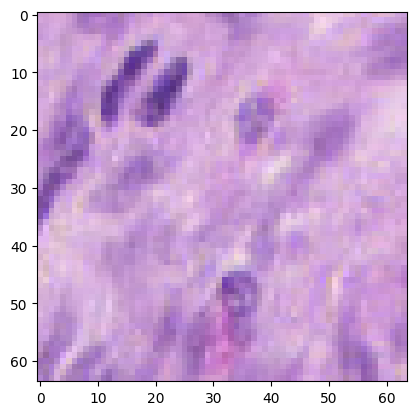

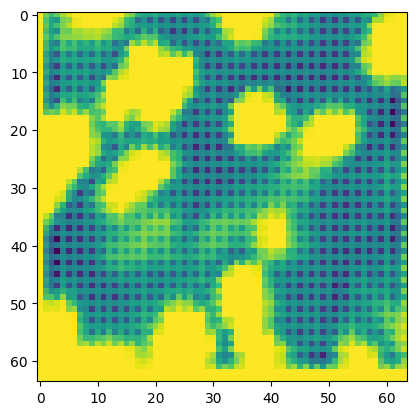

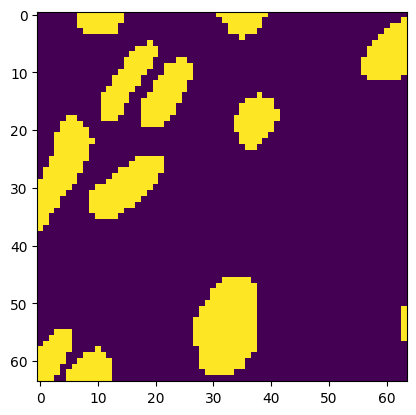

Current step: 1010  Loss: 0.2498205602169037  Acc: 0.8642425537109375  AllocMem (Mb): 0.0
Current step: 1020  Loss: 0.24392396211624146  Acc: 0.85772705078125  AllocMem (Mb): 0.0
Current step: 1030  Loss: 0.2996077537536621  Acc: 0.8127365112304688  AllocMem (Mb): 0.0
Current step: 1040  Loss: 0.305957555770874  Acc: 0.8104324340820312  AllocMem (Mb): 0.0
Current step: 1050  Loss: 0.2687367796897888  Acc: 0.8354339599609375  AllocMem (Mb): 0.0
Current step: 1060  Loss: 0.2962472438812256  Acc: 0.8127593994140625  AllocMem (Mb): 0.0
Current step: 1070  Loss: 0.23784686625003815  Acc: 0.8704605102539062  AllocMem (Mb): 0.0
Current step: 1080  Loss: 0.2540279030799866  Acc: 0.8432998657226562  AllocMem (Mb): 0.0
Current step: 1090  Loss: 0.2486046403646469  Acc: 0.8481674194335938  AllocMem (Mb): 0.0
Current step: 1100  Loss: 0.2509917616844177  Acc: 0.8521347045898438  AllocMem (Mb): 0.0


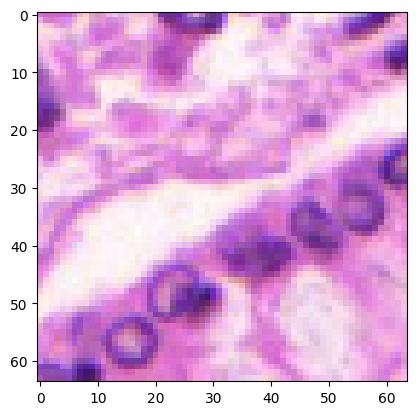

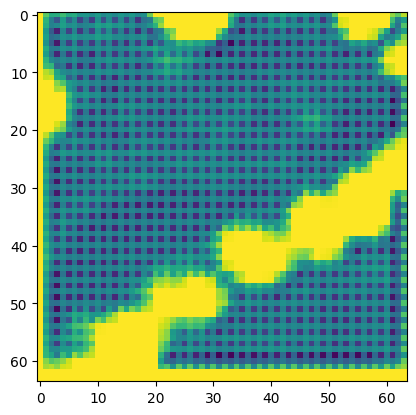

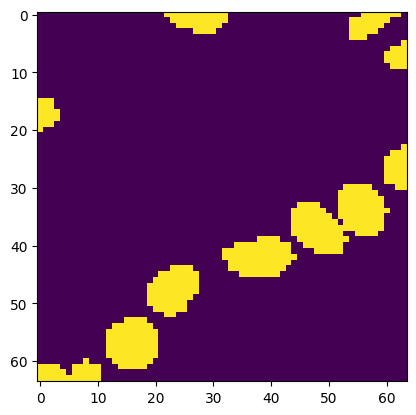

Current step: 1110  Loss: 0.2843742072582245  Acc: 0.8100204467773438  AllocMem (Mb): 0.0
Current step: 1120  Loss: 0.2691236138343811  Acc: 0.8241348266601562  AllocMem (Mb): 0.0
Current step: 1130  Loss: 0.26565542817115784  Acc: 0.829498291015625  AllocMem (Mb): 0.0
Current step: 1140  Loss: 0.24870339035987854  Acc: 0.8439407348632812  AllocMem (Mb): 0.0
Current step: 1150  Loss: 0.2886725664138794  Acc: 0.8094711303710938  AllocMem (Mb): 0.0
Current step: 1160  Loss: 0.2798047959804535  Acc: 0.8157272338867188  AllocMem (Mb): 0.0
Current step: 1170  Loss: 0.25797462463378906  Acc: 0.8395538330078125  AllocMem (Mb): 0.0
Current step: 1180  Loss: 0.22563263773918152  Acc: 0.8604049682617188  AllocMem (Mb): 0.0
Current step: 1190  Loss: 0.25033220648765564  Acc: 0.8377838134765625  AllocMem (Mb): 0.0
Current step: 1200  Loss: 0.29351717233657837  Acc: 0.805267333984375  AllocMem (Mb): 0.0


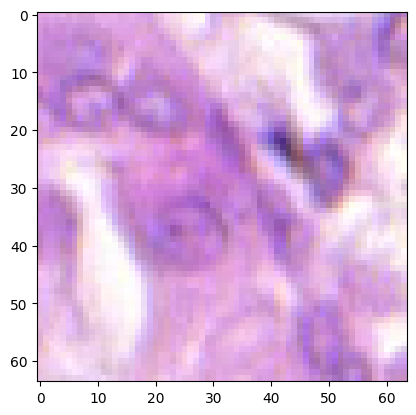

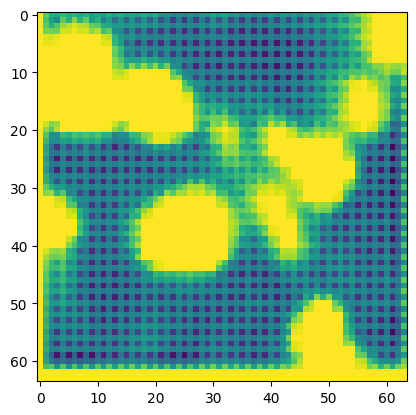

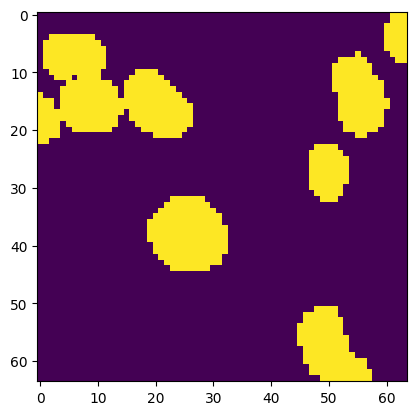

Current step: 1210  Loss: 0.2185434103012085  Acc: 0.8830718994140625  AllocMem (Mb): 0.0
Current step: 1220  Loss: 0.2705298960208893  Acc: 0.8257827758789062  AllocMem (Mb): 0.0
Current step: 1230  Loss: 0.22760145366191864  Acc: 0.860137939453125  AllocMem (Mb): 0.0
Current step: 1240  Loss: 0.2550414800643921  Acc: 0.842498779296875  AllocMem (Mb): 0.0
Current step: 1250  Loss: 0.23962050676345825  Acc: 0.8526687622070312  AllocMem (Mb): 0.0
Current step: 1260  Loss: 0.25690776109695435  Acc: 0.83111572265625  AllocMem (Mb): 0.0
Current step: 1270  Loss: 0.24030494689941406  Acc: 0.8491744995117188  AllocMem (Mb): 0.0
Current step: 1280  Loss: 0.28403785824775696  Acc: 0.8062744140625  AllocMem (Mb): 0.0
Current step: 1290  Loss: 0.25159865617752075  Acc: 0.8387603759765625  AllocMem (Mb): 0.0
Current step: 1300  Loss: 0.24806368350982666  Acc: 0.8447418212890625  AllocMem (Mb): 0.0


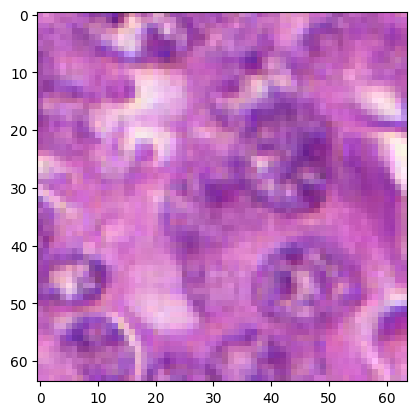

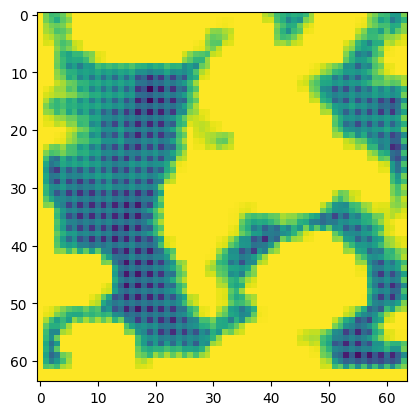

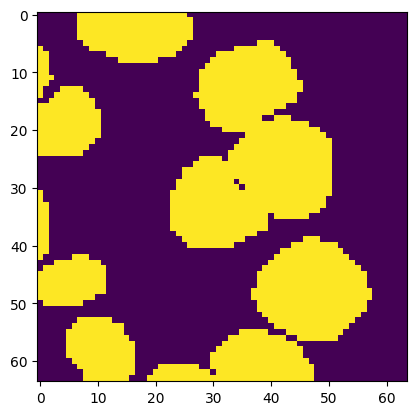

Current step: 1310  Loss: 0.24029827117919922  Acc: 0.845184326171875  AllocMem (Mb): 0.0
Current step: 1320  Loss: 0.2301122099161148  Acc: 0.8622970581054688  AllocMem (Mb): 0.0
Current step: 1330  Loss: 0.25161153078079224  Acc: 0.8451080322265625  AllocMem (Mb): 0.0
Current step: 1340  Loss: 0.23814643919467926  Acc: 0.8473052978515625  AllocMem (Mb): 0.0
Current step: 1350  Loss: 0.24162040650844574  Acc: 0.8380203247070312  AllocMem (Mb): 0.0
Current step: 1360  Loss: 0.24666830897331238  Acc: 0.8328475952148438  AllocMem (Mb): 0.0
Current step: 1370  Loss: 0.2616541087627411  Acc: 0.8309249877929688  AllocMem (Mb): 0.0
Current step: 1380  Loss: 0.2484811544418335  Acc: 0.8444442749023438  AllocMem (Mb): 0.0
Current step: 1390  Loss: 0.23203648626804352  Acc: 0.8576202392578125  AllocMem (Mb): 0.0
Current step: 1400  Loss: 0.27480703592300415  Acc: 0.81854248046875  AllocMem (Mb): 0.0


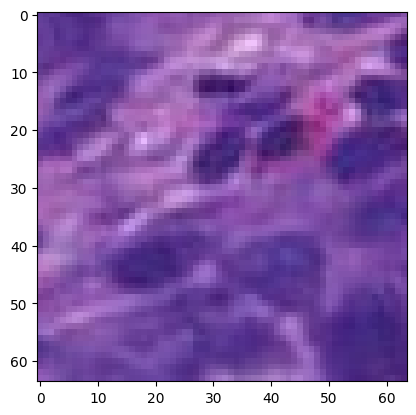

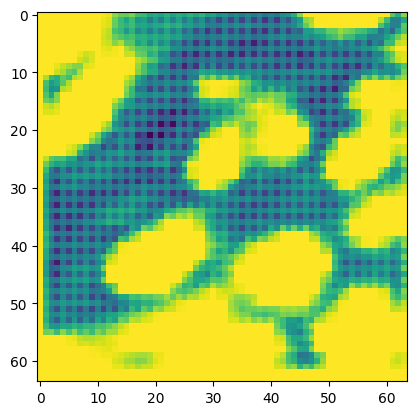

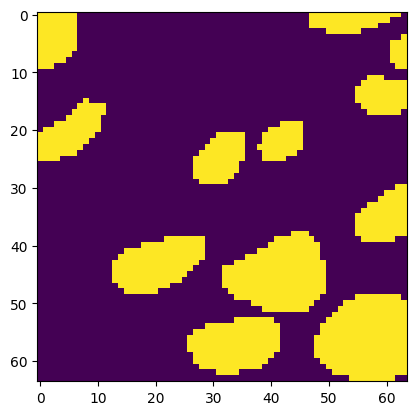

Current step: 1410  Loss: 0.25272640585899353  Acc: 0.8288421630859375  AllocMem (Mb): 0.0
Current step: 1420  Loss: 0.25516074895858765  Acc: 0.8269424438476562  AllocMem (Mb): 0.0
Current step: 1430  Loss: 0.22004957497119904  Acc: 0.8678207397460938  AllocMem (Mb): 0.0
Current step: 1440  Loss: 0.23286473751068115  Acc: 0.8514022827148438  AllocMem (Mb): 0.0
Current step: 1450  Loss: 0.25313007831573486  Acc: 0.84375  AllocMem (Mb): 0.0
Current step: 1460  Loss: 0.21999436616897583  Acc: 0.8561172485351562  AllocMem (Mb): 0.0
Current step: 1470  Loss: 0.26907607913017273  Acc: 0.8182296752929688  AllocMem (Mb): 0.0
Current step: 1480  Loss: 0.22941701114177704  Acc: 0.859588623046875  AllocMem (Mb): 0.0
Current step: 1490  Loss: 0.23555031418800354  Acc: 0.8659591674804688  AllocMem (Mb): 0.0
Current step: 1500  Loss: 0.2861398756504059  Acc: 0.80029296875  AllocMem (Mb): 0.0


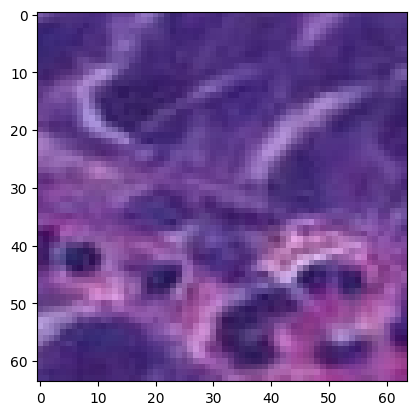

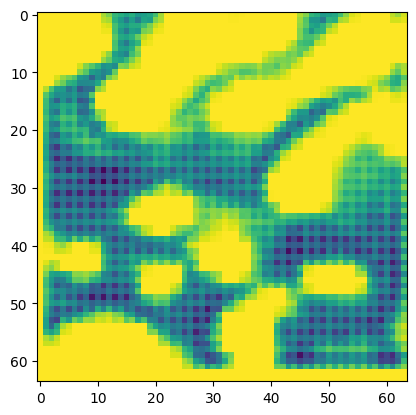

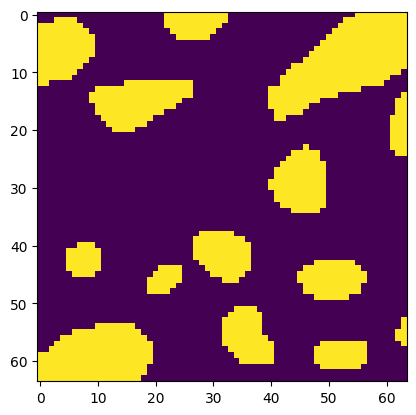

Current step: 1510  Loss: 0.23589661717414856  Acc: 0.8396530151367188  AllocMem (Mb): 0.0
Current step: 1520  Loss: 0.24040810763835907  Acc: 0.8406524658203125  AllocMem (Mb): 0.0
Current step: 1530  Loss: 0.22304993867874146  Acc: 0.865570068359375  AllocMem (Mb): 0.0
Current step: 1540  Loss: 0.23336613178253174  Acc: 0.855682373046875  AllocMem (Mb): 0.0
Current step: 1550  Loss: 0.28340914845466614  Acc: 0.8036651611328125  AllocMem (Mb): 0.0
Current step: 1560  Loss: 0.20453011989593506  Acc: 0.87994384765625  AllocMem (Mb): 0.0
Current step: 1570  Loss: 0.2714250087738037  Acc: 0.8217849731445312  AllocMem (Mb): 0.0
Current step: 1580  Loss: 0.23815327882766724  Acc: 0.8449325561523438  AllocMem (Mb): 0.0
Current step: 1590  Loss: 0.253909170627594  Acc: 0.8248367309570312  AllocMem (Mb): 0.0
Current step: 1600  Loss: 0.27835893630981445  Acc: 0.8101654052734375  AllocMem (Mb): 0.0


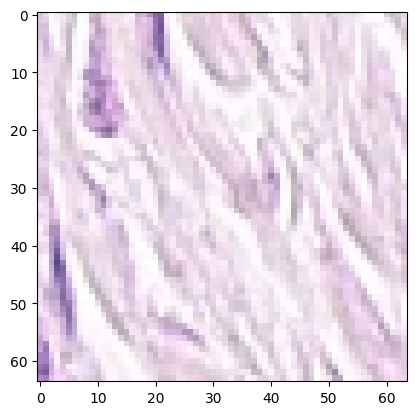

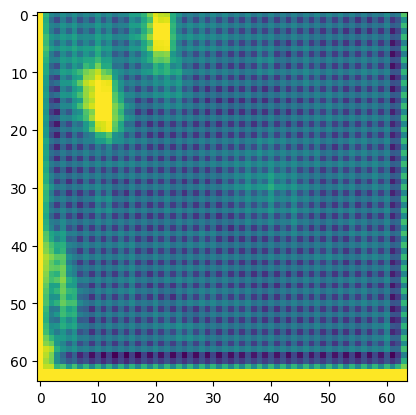

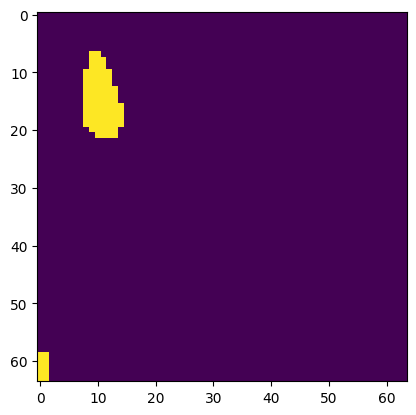

Current step: 1610  Loss: 0.23003768920898438  Acc: 0.8507003784179688  AllocMem (Mb): 0.0
Current step: 1620  Loss: 0.2765405774116516  Acc: 0.800750732421875  AllocMem (Mb): 0.0
Current step: 1630  Loss: 0.22263911366462708  Acc: 0.852386474609375  AllocMem (Mb): 0.0
Current step: 1640  Loss: 0.23890510201454163  Acc: 0.83380126953125  AllocMem (Mb): 0.0
Current step: 1650  Loss: 0.265722393989563  Acc: 0.82611083984375  AllocMem (Mb): 0.0
Current step: 1660  Loss: 0.2234290987253189  Acc: 0.861907958984375  AllocMem (Mb): 0.0
Current step: 1670  Loss: 0.20340511202812195  Acc: 0.880615234375  AllocMem (Mb): 0.0
Current step: 1680  Loss: 0.22531631588935852  Acc: 0.8489151000976562  AllocMem (Mb): 0.0
Current step: 1690  Loss: 0.24667130410671234  Acc: 0.836761474609375  AllocMem (Mb): 0.0
Current step: 1700  Loss: 0.22788995504379272  Acc: 0.85400390625  AllocMem (Mb): 0.0


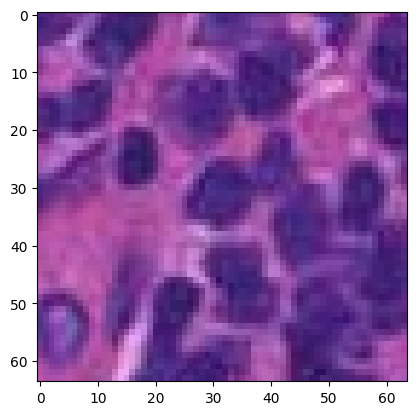

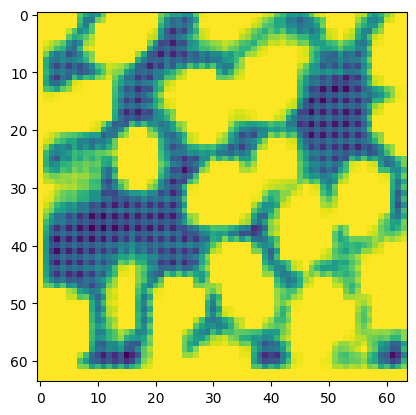

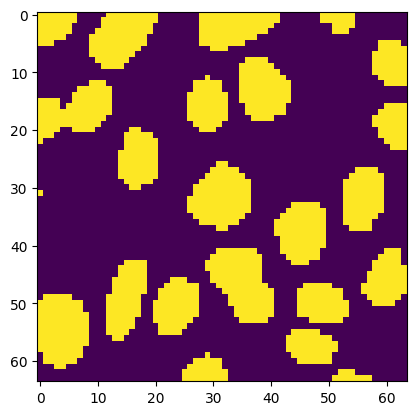

Current step: 1710  Loss: 0.2294938564300537  Acc: 0.8475723266601562  AllocMem (Mb): 0.0
Current step: 1720  Loss: 0.2508087456226349  Acc: 0.8346023559570312  AllocMem (Mb): 0.0
Current step: 1730  Loss: 0.23434562981128693  Acc: 0.8308563232421875  AllocMem (Mb): 0.0
Current step: 1740  Loss: 0.2671557068824768  Acc: 0.8176651000976562  AllocMem (Mb): 0.0
Current step: 1750  Loss: 0.21173453330993652  Acc: 0.868072509765625  AllocMem (Mb): 0.0
Current step: 1760  Loss: 0.25773972272872925  Acc: 0.8221588134765625  AllocMem (Mb): 0.0
Current step: 1770  Loss: 0.25993582606315613  Acc: 0.8224105834960938  AllocMem (Mb): 0.0
Current step: 1780  Loss: 0.20925132930278778  Acc: 0.8724288940429688  AllocMem (Mb): 0.0
Current step: 1790  Loss: 0.21543912589550018  Acc: 0.8724517822265625  AllocMem (Mb): 0.0
Current step: 1800  Loss: 0.24801188707351685  Acc: 0.83636474609375  AllocMem (Mb): 0.0


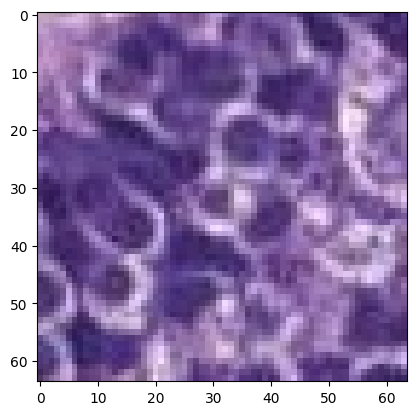

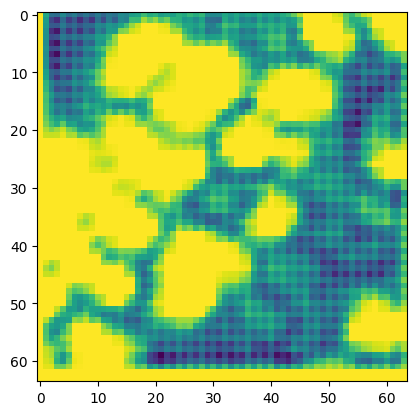

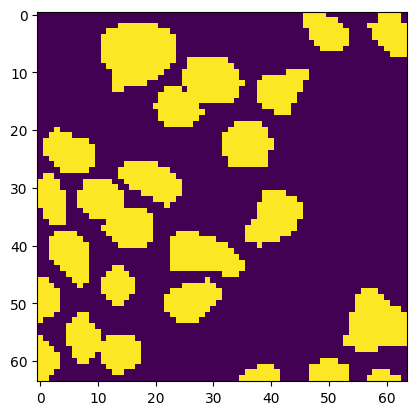

Current step: 1810  Loss: 0.22509044408798218  Acc: 0.8545913696289062  AllocMem (Mb): 0.0
Current step: 1820  Loss: 0.2563941180706024  Acc: 0.8283615112304688  AllocMem (Mb): 0.0
Current step: 1830  Loss: 0.20007890462875366  Acc: 0.883636474609375  AllocMem (Mb): 0.0
Current step: 1840  Loss: 0.2537860870361328  Acc: 0.8286666870117188  AllocMem (Mb): 0.0
Current step: 1850  Loss: 0.2620590925216675  Acc: 0.8190765380859375  AllocMem (Mb): 0.0
Current step: 1860  Loss: 0.23442476987838745  Acc: 0.8441085815429688  AllocMem (Mb): 0.0
Current step: 1870  Loss: 0.20629866421222687  Acc: 0.8661270141601562  AllocMem (Mb): 0.0
Current step: 1880  Loss: 0.21550670266151428  Acc: 0.86016845703125  AllocMem (Mb): 0.0
Current step: 1890  Loss: 0.2489616870880127  Acc: 0.8303375244140625  AllocMem (Mb): 0.0
Current step: 1900  Loss: 0.24885819852352142  Acc: 0.8304672241210938  AllocMem (Mb): 0.0


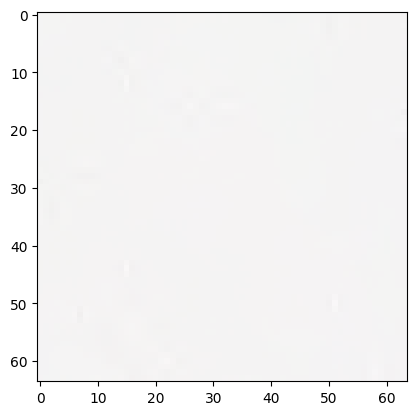

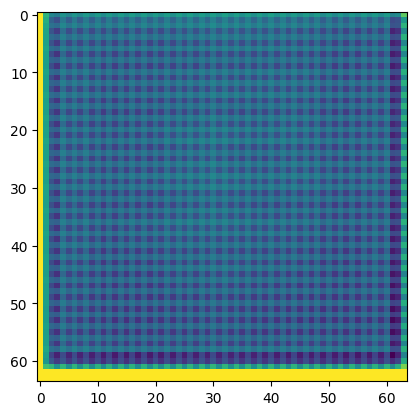

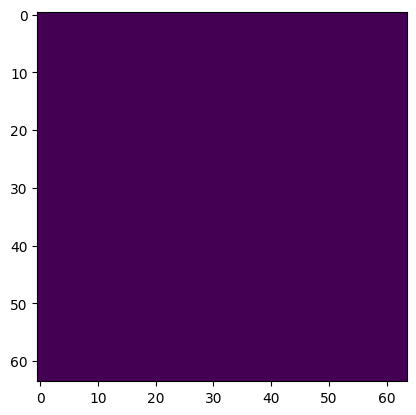

Current step: 1910  Loss: 0.20667877793312073  Acc: 0.8712997436523438  AllocMem (Mb): 0.0
Current step: 1920  Loss: 0.21898750960826874  Acc: 0.8576889038085938  AllocMem (Mb): 0.0
Current step: 1930  Loss: 0.20455797016620636  Acc: 0.86602783203125  AllocMem (Mb): 0.0
Current step: 1940  Loss: 0.24239501357078552  Acc: 0.8253860473632812  AllocMem (Mb): 0.0
Current step: 1950  Loss: 0.22226406633853912  Acc: 0.8580474853515625  AllocMem (Mb): 0.0
Current step: 1960  Loss: 0.23039788007736206  Acc: 0.853912353515625  AllocMem (Mb): 0.0
Current step: 1970  Loss: 0.27930396795272827  Acc: 0.7992401123046875  AllocMem (Mb): 0.0
Current step: 1980  Loss: 0.25560128688812256  Acc: 0.8237991333007812  AllocMem (Mb): 0.0
Current step: 1990  Loss: 0.25300726294517517  Acc: 0.8174209594726562  AllocMem (Mb): 0.0
Current step: 2000  Loss: 0.24123528599739075  Acc: 0.8305816650390625  AllocMem (Mb): 0.0


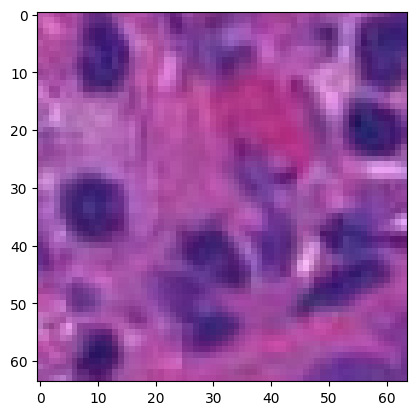

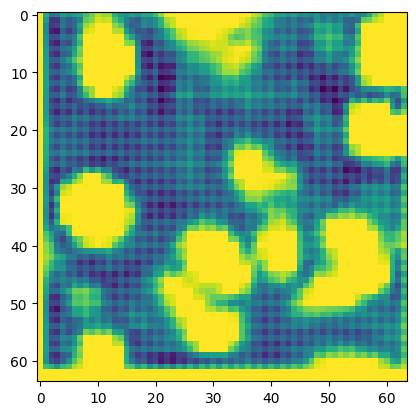

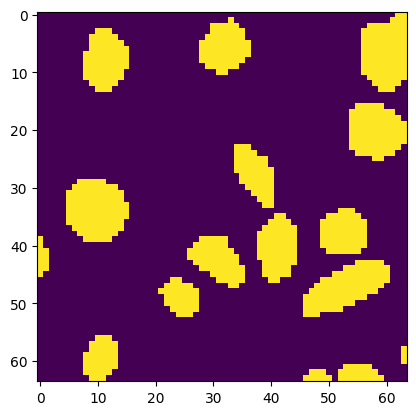

Current step: 2010  Loss: 0.20668211579322815  Acc: 0.861846923828125  AllocMem (Mb): 0.0
Current step: 2020  Loss: 0.21531575918197632  Acc: 0.841827392578125  AllocMem (Mb): 0.0
Current step: 2030  Loss: 0.22050179541110992  Acc: 0.8497390747070312  AllocMem (Mb): 0.0
Current step: 2040  Loss: 0.23161278665065765  Acc: 0.8358306884765625  AllocMem (Mb): 0.0
Current step: 2050  Loss: 0.23196616768836975  Acc: 0.845794677734375  AllocMem (Mb): 0.0
Current step: 2060  Loss: 0.23520918190479279  Acc: 0.8529205322265625  AllocMem (Mb): 0.0
Current step: 2070  Loss: 0.24013271927833557  Acc: 0.8249130249023438  AllocMem (Mb): 0.0
Current step: 2080  Loss: 0.21125414967536926  Acc: 0.857147216796875  AllocMem (Mb): 0.0
Current step: 2090  Loss: 0.2144888937473297  Acc: 0.8583984375  AllocMem (Mb): 0.0
Current step: 2100  Loss: 0.22438502311706543  Acc: 0.8459930419921875  AllocMem (Mb): 0.0


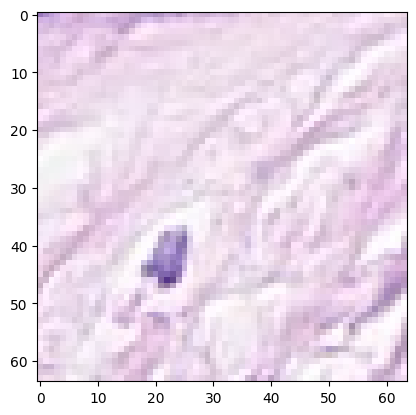

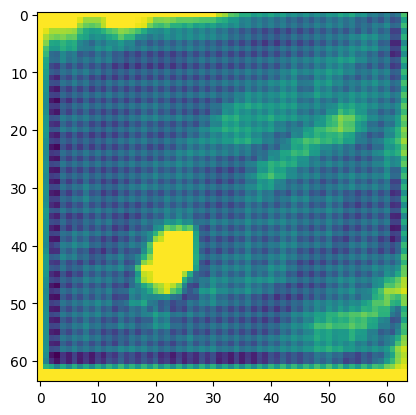

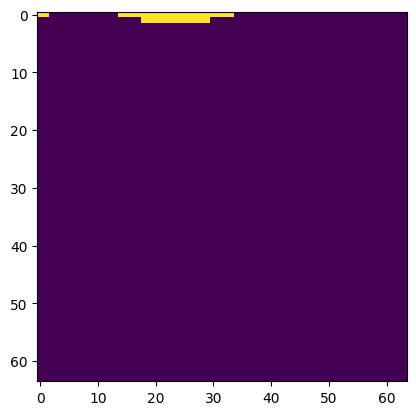

Current step: 2110  Loss: 0.23582157492637634  Acc: 0.8427886962890625  AllocMem (Mb): 0.0
Current step: 2120  Loss: 0.20096273720264435  Acc: 0.8682098388671875  AllocMem (Mb): 0.0
Current step: 2130  Loss: 0.256386399269104  Acc: 0.8150405883789062  AllocMem (Mb): 0.0
Current step: 2140  Loss: 0.2291995882987976  Acc: 0.84375  AllocMem (Mb): 0.0
Current step: 2150  Loss: 0.2550182342529297  Acc: 0.8153762817382812  AllocMem (Mb): 0.0
Current step: 2160  Loss: 0.2072857767343521  Acc: 0.8678054809570312  AllocMem (Mb): 0.0
Current step: 2170  Loss: 0.2449798882007599  Acc: 0.8357620239257812  AllocMem (Mb): 0.0
Current step: 2180  Loss: 0.2557605504989624  Acc: 0.8165283203125  AllocMem (Mb): 0.0
Current step: 2190  Loss: 0.2638491988182068  Acc: 0.8115158081054688  AllocMem (Mb): 0.0
Current step: 2200  Loss: 0.21730756759643555  Acc: 0.851104736328125  AllocMem (Mb): 0.0


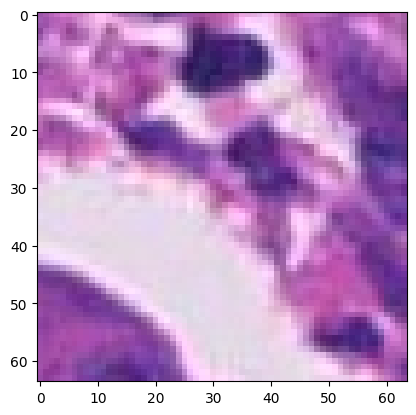

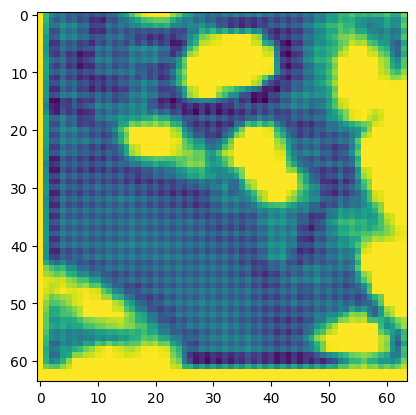

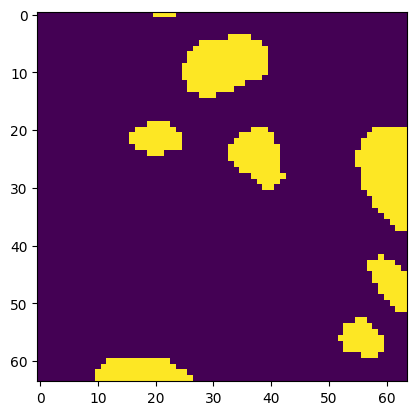

Current step: 2210  Loss: 0.24967288970947266  Acc: 0.8157501220703125  AllocMem (Mb): 0.0
Current step: 2220  Loss: 0.20634697377681732  Acc: 0.8654403686523438  AllocMem (Mb): 0.0
Current step: 2230  Loss: 0.18560245633125305  Acc: 0.9023666381835938  AllocMem (Mb): 0.0
Current step: 2240  Loss: 0.2483416348695755  Acc: 0.822265625  AllocMem (Mb): 0.0
Current step: 2250  Loss: 0.24398578703403473  Acc: 0.8291168212890625  AllocMem (Mb): 0.0
Current step: 2260  Loss: 0.2535858154296875  Acc: 0.8000259399414062  AllocMem (Mb): 0.0
Current step: 2270  Loss: 0.21296384930610657  Acc: 0.85687255859375  AllocMem (Mb): 0.0
Current step: 2280  Loss: 0.17947781085968018  Acc: 0.9027252197265625  AllocMem (Mb): 0.0
Current step: 2290  Loss: 0.2398710548877716  Acc: 0.8328704833984375  AllocMem (Mb): 0.0
Current step: 2300  Loss: 0.2833693027496338  Acc: 0.783294677734375  AllocMem (Mb): 0.0


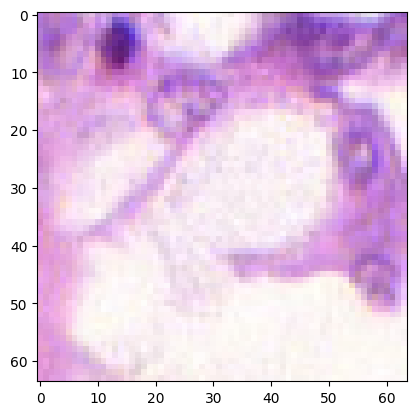

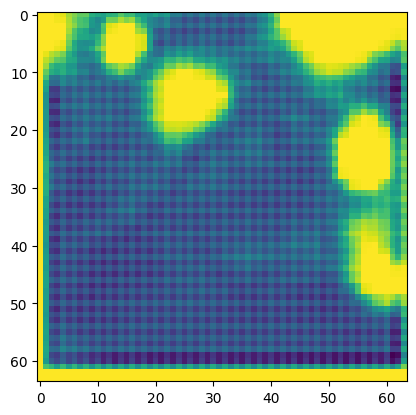

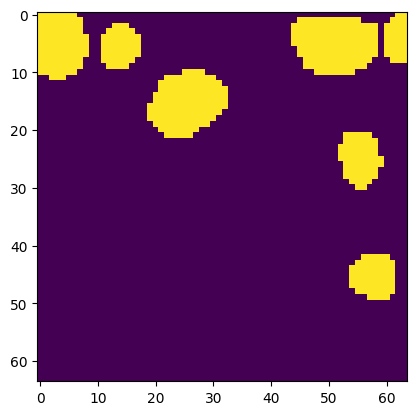

Current step: 2310  Loss: 0.19468426704406738  Acc: 0.8823318481445312  AllocMem (Mb): 0.0
Current step: 2320  Loss: 0.20164315402507782  Acc: 0.8577880859375  AllocMem (Mb): 0.0
Current step: 2330  Loss: 0.23328417539596558  Acc: 0.8280487060546875  AllocMem (Mb): 0.0
Current step: 2340  Loss: 0.24443718791007996  Acc: 0.8232879638671875  AllocMem (Mb): 0.0
Current step: 2350  Loss: 0.2144995927810669  Acc: 0.8534164428710938  AllocMem (Mb): 0.0
Current step: 2360  Loss: 0.2055199295282364  Acc: 0.8652725219726562  AllocMem (Mb): 0.0
Current step: 2370  Loss: 0.23212473094463348  Acc: 0.8355865478515625  AllocMem (Mb): 0.0
Current step: 2380  Loss: 0.24339158833026886  Acc: 0.8421630859375  AllocMem (Mb): 0.0
Current step: 2390  Loss: 0.1870858073234558  Acc: 0.8807144165039062  AllocMem (Mb): 0.0
Current step: 2400  Loss: 0.22000430524349213  Acc: 0.8479232788085938  AllocMem (Mb): 0.0


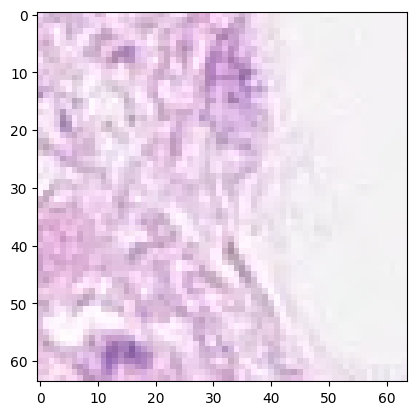

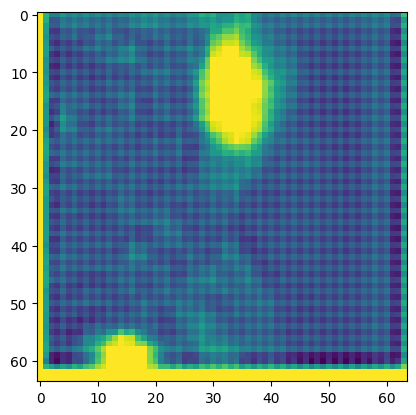

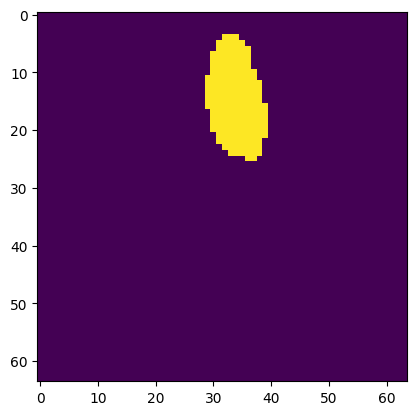

Current step: 2410  Loss: 0.2221454530954361  Acc: 0.8546066284179688  AllocMem (Mb): 0.0
Current step: 2420  Loss: 0.24784089624881744  Acc: 0.8152542114257812  AllocMem (Mb): 0.0
Current step: 2430  Loss: 0.23348669707775116  Acc: 0.8344345092773438  AllocMem (Mb): 0.0
Current step: 2440  Loss: 0.2003992795944214  Acc: 0.8626480102539062  AllocMem (Mb): 0.0
Current step: 2450  Loss: 0.19641602039337158  Acc: 0.8822174072265625  AllocMem (Mb): 0.0


KeyboardInterrupt: 

In [16]:
net = UNET(3, 1)
loss_fn = nn.BCEWithLogitsLoss()
opt = torch.optim.Adam(net.parameters(), lr=0.001)
train_loss, valid_loss = train(net, train_dl, valid_dl, loss_fn, opt, acc_metric, epochs=5)